## NLP exploration on plot summaries

In [13]:
# Import the needed libarairies
import warnings # to ignore pandas version warning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_ind, spearmanr # to implement statistical tests
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans # for actors analysis
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from itertools import zip_longest # to iterate over many lists at the same time

############# NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim
import pyLDAvis.gensim_models
import vaderSentiment # Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from collections import Counter # to count tokens in each plot summaries
import pickle # in order to open the lexicon of american words

import torch # for fatser NLP processing

In [2]:
########################### Read datasets from repository's data folder ############################
movie_mtd = pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
actor_mtd = pd.read_table('data/actor_metadata_CMU.csv', sep=',')
personas_mtd = pd.read_table('data/personas_metadata_CMU.csv', sep=',')

plot_summaries_df = pd.read_csv('data/plot_summaries_CMU.csv', sep = ',', usecols= ['ID', 'Summary'])

In [33]:
# Set a global background theme for all our plots and ignore warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

### Subdataset creation to faciliates the analysis

In [3]:
# Creating deep copies of original data frame to avoid messing it up
all_movies = movie_mtd.copy() # all movies in the dataset, no matter their production country
us_movies = movie_mtd.copy() 
us_partially_movies = movie_mtd.copy()
all_us_movies = movie_mtd.copy()
rest_world_non_US = movie_mtd.copy()

## Filtering the newly created dataframes for the analysis of nox office revenue, IMDb ratings and runtimes
# Movies strictly produced in the US
us_movies = us_movies[us_movies['countries'] == 'United States of America']
# Movies partially produced in the US
us_partially_movies = us_partially_movies[(us_partially_movies['countries'].str.contains('United States of America') == True) & (us_partially_movies['countries'] != 'United States of America')]
# Contains the movies strictly produced in the US and the ones partially produced in the US
all_us_movies = all_us_movies[(all_us_movies['countries'] == 'United States of America') | (all_us_movies['countries'].str.contains('United States of America') == True)]

# Non-US movies
rest_world_non_US = rest_world_non_US[(rest_world_non_US['countries'].str.contains('United States of America') == False) & (rest_world_non_US['countries'] != 'United States of America')]

In [4]:
us_movies.head()

,wiki_movie_ID,freebase_movie_ID,title,release_date,box_office,runtime,languages,countries,genres_CMU,release_year,genres_IMDB,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0,"Action,Horror,Sci-Fi",4.9,58894.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenet Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0,NaN,NaN,NaN
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"Silent film, English Language",United States of America,"Short Film, Silent film, Indie, Black-and-whit...",1913.0,"Comedy,Short",7.2,19.0
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,English Language,United States of America,"Musical, Comedy, Black-and-white",1938.0,"Drama,Music,Musical",6.8,2357.0
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,English Language,United States of America,"Drama, Black-and-white",1930.0,"Drama,Romance",5.4,356.0


### Opening of the Plot summaries dataset

In [5]:
# Increase the display width to see more characters per column
pd.set_option('display.max_colwidth', None)  # This removes the column width limit

# Display the first 3 lines of each summary in the 'Summary' column
plot_summaries_df['Preview'] = plot_summaries_df['Summary'].apply(lambda x: ' '.join(x.split()[:50])) # x.split() splits the text into individual words, .join rebuilds the string after
# splitlines() to split into separate lines if the text already contains line breaks

# Show the first few rows with the Preview column
plot_summaries_df[['ID', 'Preview']].head()

# sort the plot summaries according to the Wikipedia movie ID
plot_summaries_df_sorted = plot_summaries_df.sort_values(ascending = True , by= 'ID')
plot_summaries_df_sorted[['ID', 'Preview']].head()

print(f"The size of the plot summaries dataset is {plot_summaries_df.shape}.")

plot_summaries_df.head()

The size of the plot summaries dataset is (42303, 3).


ID  \
0  23890098   
1  31186339   
2  20663735   
3   2231378   
4    595909   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Merging the plot summaries dataset with the movie_mtd dataset in order to distinguish between US-only. partially US and non US produced movies

In [8]:
# Performing inner joins to be sure each movie kept after the merge has a plot summaries and filtering to keep only useful columnbs for the rest of the analysis
# ID column is not useful anymore so one can remove it
plot_summaries_all_movies = pd.merge(plot_summaries_df, all_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title', 'Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)
#.drop(columns= ['Preview', 'wiki_movie_ID', 'freebase_movie_ID', 'release_date', 'runtime', 'countries', 'genres_CMU'], inplace= True)

plot_summaries_us_movies = pd.merge(plot_summaries_df, us_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title','Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_us_partially_movies = pd.merge(plot_summaries_df, us_partially_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title', 'Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_RoW_movies = pd.merge(plot_summaries_df, rest_world_non_US, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title','Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

print(f"The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is {plot_summaries_all_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is {plot_summaries_us_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is {plot_summaries_us_partially_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is {plot_summaries_RoW_movies.shape}.")

plot_summaries_us_movies.head()

The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is (42208, 7).
The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is (17776, 7).
The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is (3015, 7).
The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is (18105, 7).


title  \
0    The Hunger Games   
1  The Lemon Drop Kid   
2          Dark Water   
3                Sing   
4       Meet John Doe   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### Basics stats on the plot summaries

In [9]:
def plot_counter(df, lower_bound=1, upper_bound=20): #setting default lower and upper bounds value
    """
    Function that counts the number of plot summaries containing a given munber or words.

    Params:
        df (pd.DataFrame): DataFrame containing a column 'Summary'.
        lower_bound (int, optional): Minimum number of words in a plot summary (exclusive).
                                     Use None to apply no lower bound. Default is 1.
        upper_bound (int, optional): Maximum number of words in a plot summary (inclusive).
                                     Default is 20.
    Returns: The count of summaries within the specified word count range (int).
    """
    if 'Summary' not in df.columns:
        raise ValueError("The dataframe must have a column named 'Summary'.")

    # Precompute word counts for efficiency
    word_counts = df['Summary'].apply(lambda x: len(str(x).split())) # split words based on white spaces

    if lower_bound is None:
        # Apply only the upper bound
        return word_counts[word_counts >= upper_bound].count()
    else:
        # Apply both lower and upper bounds
        return word_counts[(word_counts > lower_bound) & (word_counts <= upper_bound)].count()

# Initializing the need lists and dictionnary
list_name_df = ['All movies', 'US-only produced movies', 'Partially US-produced movies', 'Non US-produced movies']
list_df_plot_summaries = [plot_summaries_all_movies, plot_summaries_us_movies, plot_summaries_us_partially_movies, plot_summaries_RoW_movies]
list_set_number_words = [[1, 20], [20, 100], [100, 300], [300,500], [500, 1000], [1000, 2000], [2000, 3000]]
dict_plot_count = {'All movies': [], 'US-only produced movies': [], 
                   'Partially US-produced movies': [], 'Non US-produced movies': [], 
                   }

# Use of "zip" will make the loop terminates when the shortest iterable is exhausted so one put it in the second for loop to make sure all the 7 words count interval are processed
dict_plot_count = {name: [] for name in list_name_df}
interval_names = [f"{low}-{high}" for low, high in list_set_number_words]

for interval in list_set_number_words:
    for df, dico_name in zip(list_df_plot_summaries, list_name_df):
        word_count = plot_counter(df, lower_bound = interval[0], upper_bound = interval[1])
        dict_plot_count[dico_name].append(word_count)

# Create DataFrame with interval names as index and title
df_count_plot_summaries = pd.DataFrame(dict_plot_count, index=interval_names)

# Add a title for the rows as an index
df_count_plot_summaries.index.name = "Word number Interval"

# Compute the total number of plot summaries for each columns and add it as the last row of the df
df_count_plot_summaries.loc["Total"] = df_count_plot_summaries.sum(axis=0)

print("The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)")
df_count_plot_summaries.head(8)


The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)


,All movies,US-only produced movies,Partially US-produced movies,Non US-produced movies
Word number Interval,,,,
1-20,397,133,11,180
20-100,12137,4639,531,5662
100-300,14406,5600,702,6905
300-500,5933,2745,450,2392
500-1000,7867,3973,1073,2501
1000-2000,1381,658,235,428
2000-3000,69,25,10,29
Total,42190,17773,3012,18097


One notices first that most of the plot summaries show a number of words between 100 and 300. Next, come the plots having 20-100 words intheir summaries. One sees that they are very few plots summaries with more than 2000 words. Finally, one sees that with those word intervals one captures nearly all the movies. Indeed, th column *total* for all the movies shows 42190 movies out of 42208 (see above cell) meaning that only 18 plots summarie shave more than 3000 words. One observe similar behavior for the US-only produced, Partially US-produced and Non Us-produced movies.

Visualization

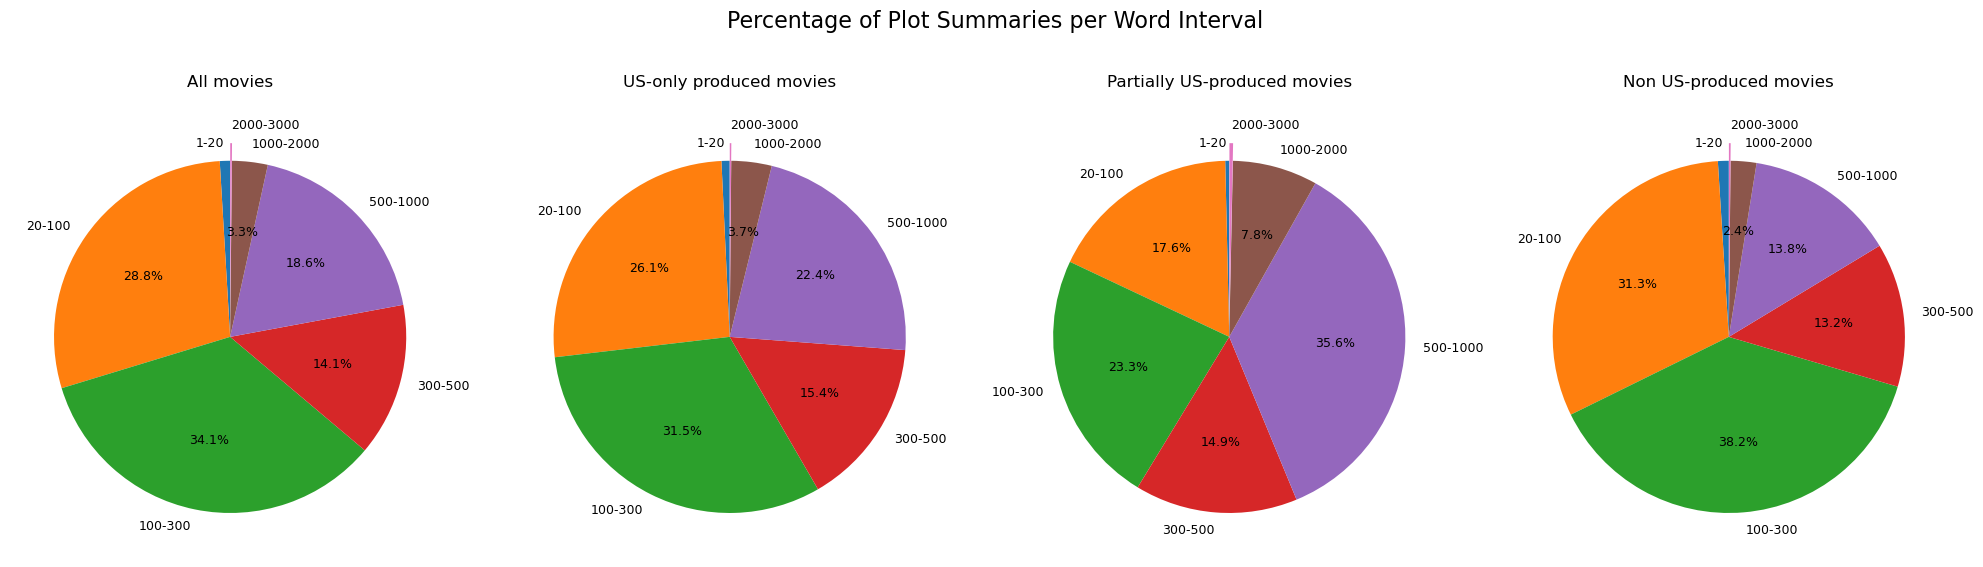

In [10]:
colors = sns.color_palette("pastel", len(df_count_plot_summaries.index))

def autopct_threshold(pct):
    return f'{pct:.1f}%' if pct > 1 else ''  # Only display if percentage > 1%

plots = df_count_plot_summaries.iloc[:-1].plot.pie(
    subplots=True,
    figsize=(20, 8),
    title= False,
    legend=False,
    autopct=autopct_threshold,
    explode=(0, 0, 0, 0, 0, 0, 0.1),
    shadow=False,
    startangle=90,
    textprops={'fontsize': 9},
    color = colors
)

# Manually set the titles above the charts
titles = df_count_plot_summaries.columns
for ax, title in zip(plots, titles):
    ax.set_title(title, fontsize=12, y=1.05)  # Adjust y to move title above
    ax.set_ylabel('')  # Remove the default title on the left

# Global adjustments
plt.suptitle("Percentage of Plot Summaries per Word Interval", fontsize=16)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.show()

## NLP

#### Preparation of the data needed to assess the american culture

Retrieve all the cities, counties and states in the US in order to create a set of the US locations. This will serve to evaluate the "percentage" of amercian culture in each plot summaries by looking at the location of where the story of the movie is happening.

In [11]:
# List of all us states, counties and cities found on: https://github.com/grammakov/USA-cities-and-states/tree/master
df_us_states_counties_cities = pd.read_csv("data/us_cities_states_counties.csv", sep = "|")
print(f"The shape of the US states, counties and cities dataset is {df_us_states_counties_cities.shape}.")

# Exclude non-offcial US states
exclude_states = [
    "US Armed Forces Pacific", "American Samoa", "Guam", "Palau",
    "Federated States of Micronesia", "Northern Mariana Islands",
    "Marshall Islands", "US Armed Forces Europe", "Puerto Rico", "Virgin Islands"
]

indices_to_drop = df_us_states_counties_cities[
    df_us_states_counties_cities['State full'].isin(exclude_states)
].index


df_us_states_counties_cities.drop(index=indices_to_drop, inplace=True)
print(f"The shape after dropping of the US states, counties and cities dataset is {df_us_states_counties_cities.shape}.")

# Create lists of unique city, county ans states names
list_US_states = list(df_us_states_counties_cities['State full'].unique())
list_US_counties = list(df_us_states_counties_cities['County'].str.capitalize().unique())
list_US_cities = list(df_us_states_counties_cities['City'].unique())

print(f"The list of the US states is \n {list_US_states} \n and contains {len(list_US_states)} states.")
print(f"The list of the US counties is \n {list_US_counties} \n and contains {len(list_US_counties)} counties.")
print(f"The list of the US cities is \n {list_US_cities} \n and contains {len(list_US_cities)} cities.")

# Combine all US states, counties, and cities into a single set for faster lookup
us_locations_set = set(list_US_states + list_US_counties + list_US_cities)

df_us_states_counties_cities.head()

The shape of the US states, counties and cities dataset is (63210, 5).
The shape after dropping of the US states, counties and cities dataset is (60451, 5).
The list of the US states is 
 ['New York', 'Massachusetts', 'Rhode Island', 'New Hampshire', 'Maine', 'Vermont', 'Connecticut', 'New Jersey', 'Pennsylvania', 'Delaware', 'Washington, D.C.', 'Virginia', 'Maryland', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Alabama', 'Tennessee', 'Mississippi', 'Kentucky', 'Ohio', 'Indiana', 'Michigan', 'Iowa', 'Wisconsin', 'Minnesota', 'South Dakota', 'North Dakota', 'Montana', 'Illinois', 'Missouri', 'Kansas', 'Nebraska', 'Louisiana', 'Arkansas', 'Oklahoma', 'Texas', 'Colorado', 'Wyoming', 'Idaho', 'Utah', 'Arizona', 'New Mexico', 'Nevada', 'California', 'Hawaii', 'Oregon', 'Washington', 'Alaska'] 
 and contains 51 states.
The list of the US counties is 
 ['Suffolk', 'Hampden', 'Hampshire', 'Worcester', 'Berkshire', 'Franklin', 'Middlesex', 'Essex', 'Plymouth', 'N

,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2696,Agawam,MA,Massachusetts,HAMPDEN,Agawam
2697,Amherst,MA,Massachusetts,HAMPSHIRE,Amherst
2698,Amherst,MA,Massachusetts,HAMPSHIRE,Cushman


Load the set of american words representing the lexicon created from Wikipedia data (see notebook *american_vocab.ipynb*) for more details

In [12]:
with open('data/unique_us_words_set.pkl', 'rb') as f:
    unique_us_words_set = pickle.load(f)

print(f"The lexicon of amercian words contains {len(unique_us_words_set)} words.")
print(unique_us_words_set)

The lexicon of amercian words contains 757 words.
{'constitutionalism', 'banjos', 'telescope', 'individualism', 'presently', 'mexican', 'curtailment', 'lincoln', 'chain', 'piedmont', 'sources', 'sexuality', 'militant', 'transportation', 'street', 'enroll', 'apollo', 'consultants', 'inspiration', 'monitor', 'accelerate', 'polar', 'censorship', 'stieglitz', 'gannett', 'federalist', 'defiance', 'tide', 'certification', 'silent', 'dam', 'portland', 'desecration', 'owner', 'collective', 'yorktown', 'incorporated', 'meadow', 'whitney', 'institutional', 'waldo', 'theater', 'experiment', 'morton', 'fill', 'podcast', 'certiorari', 'hasten', 'dozen', 'gritty', 'prisons', 'factory', 'rhythm', 'distance', 'menu', 'guitar', 'tornado', 'back', 'midwestern', 'graduate', 'purview', 'mars', 'totality', 'ten', 'likewise', 'clash', 'plymouth', 'rechargeable', 'vice', 'cdc', 'kooning', 'species', 'confederates', 'bhutan', 'movie', 'resignation', 'ample', 'frances', 'bureau', 'submit', 'dickinson', 'ideolo

#### Assessing the american culture in plots summaries using GPE (location only)

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Creating deep copy of the plots_summaries dataframes creatde above 
df_plots_all_movies_GPE = plot_summaries_all_movies.copy()
df_plots_us_movies_GPE = plot_summaries_us_movies.copy()
df_plots_us_partially_movies_GPE = plot_summaries_us_partially_movies.copy() # run en 5'30"
df_plots_RoW_GPE = plot_summaries_RoW_movies.copy()

# since GPE is part of the NER spacy pipeline, no need to tokenize manually the text before implementing the search for GPE quantities
# def extract_gpe(summary):
#     """ Function that extract the GPE entities of a plot summary
#     params: a text called 'summary'
#     returns: all the GPE entities detected in the summary
#     """
#     doc = nlp(summary)
#     return [ent.text for ent in doc.ents if ent.label_ == 'GPE'] # outputs all detected geopolitical entities, including repeated mentions of the same geographical entitities

# def compute_US_GPE_frequencies(summary, set_us_location):
#     """ Function that extract the US GPE frequencies of a plot summary
#     params: a text called 'summary' and a set of US locations containing the cities, counties and the states
#     returns: all the US GPE frequencies detected in the summary
#     """

def extract_GPE_and_compute_US_frequencies(summary, set_us_location):
    """ Function that extract the GPE entities of a plot summary
    params: a text called 'summary' and a set of US locations containing the cities, counties and the states
    returns: all the GPE entities and all the US GPE frequencies detected in the summary
    """
    doc = nlp(summary)
    GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    GPE_frequencies_all = Counter(GPE_entities)
    GPE_US_frequencies = Counter(entity for entity in GPE_entities if entity in set_us_location)
    Percentage_US_culture = sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values()) if sum(GPE_frequencies_all.values()) > 0 else 0
    return GPE_entities, GPE_US_frequencies, Percentage_US_culture

# Unpacking the results of the function
df_plots_us_partially_movies_GPE['GPE_entities'], df_plots_us_partially_movies_GPE['GPE_US_frequencies'], df_plots_us_partially_movies_GPE['Percentage_american_culture'] = df_plots_us_partially_movies_GPE['Summary'].apply(extract_GPE_and_compute_US_frequencies)


# df_plots_us_partially_movies_GPE['GPE_frequencies'] = df_plots_us_partially_movies_GPE['GPE_entities'].apply(
#     lambda entities: Counter(entities) # use of library Counzter for efficient processing
# ) # ENLEVER POUR LA SUITE



# Filter GPE entities to retain only those matching US locations
# df_plots_us_partially_movies_GPE['GPE_US_frequencies'] = df_plots_us_partially_movies_GPE['GPE_entities'].apply(
#     lambda entities: Counter(entity for entity in entities if entity in us_locations_set)
# )

# "Percentage" of american culture
# df_plots_us_partially_movies_GPE['Percentage_american_culture'] = df_plots_us_partially_movies_GPE.apply(
#     lambda row: sum(row['GPE_US_frequencies'].values()) / sum(row['GPE_frequencies'].values())
#     if sum(row['GPE_frequencies'].values()) > 0 else 0,
#     axis=1
# )

df_plots_us_partially_movies_GPE.head()


,ID,Summary,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_frequencies,GPE_US_frequencies,Percentage_american_culture
0,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy returns to the tent to check on Azaria and is certain she sees a dingo with something in its mouth running off as she approaches. When she discovers the infant is missing, everyone joins forces to search for her, without success. It is assumed what Lindy saw was the animal carrying off the child, and a subsequent inquest rules her account of events is true. The tide of public opinion soon turns against the Chamberlains. For many, Lindy seems too stoic, too cold-hearted, and too accepting of the disaster that has befallen her. Gossip about her begins to swell and soon is accepted as statements of fact. The couple's beliefs are not widely practised in the country, and when the media report a rumour that the name Azaria means ""sacrifice in the wilderness"" , the public is quick to believe they decapitated their baby with a pair of scissors as part of a bizarre religious rite. Law-enforcement officials find new witnesses, forensics experts, and a lot of circumstantial evidence—including a small wooden coffin Michael uses as a receptacle for his parishioners' packs of un-smoked cigarettes—and reopen the investigation, and eventually Lindy is charged with murder. Seven months pregnant, she ignores her attorneys' advice to play on the jury's sympathy and appears emotionless on the stand, convincing onlookers she is guilty of the crime of which she is accused. As the trial progresses, Michael's faith in his religion and his belief in his wife disintegrate, and he stumbles through his testimony, suggesting he is concealing the truth. In October 1982, Lindy is found guilty and sentenced to life imprisonment with hard labour, while Michael is found guilty as an accessory and given an 18-month suspended sentence. More than three years later, while searching for the body of an English tourist who fell from Uluru, police discover a small item of clothing that is identified as the jacket Lindy had insisted Azaria was wearing over her jumpsuit, which had been recovered early in the investigation. She is immediately released from prison, the case reopened and all convictions against the Chamberlains overturned.",A Cry in the Dark,6908797.0,NaN,1988.0,NaN,NaN,"[Azaria, Lindy, Lindy, Uluru]","{'Azaria': 1, 'Lindy': 2, 'Uluru': 1}",{},0.000000
1,5272176,"The president is on his way to give a speech. While he is traveling there a man shows up with a camera. A reporter tries to ask a member of the secret service a question. When the president enters he is shot by the man with the camera. The president's main bodyguard, Alex Thomas , is grazed by the bullet that hits the president. The shooter is gunned down by Alex and other secret service agents. The president dies at the hospital. Kate Crawford , an investigative journalist, starts asking questions about the assassination. Anyone she questions is killed. She goes to Alex Thomas's house to tell him what is happening. As they head to his boat, Thomas sees some men hiding in the bushes. He throws Kate into the water and dives in. Thomas jumps out of the water to kill two of the hitmen while a third hitman drives off to inform his boss what happened. They are able to link the hitmen to a man called Jack Baldwin . Agent Thomas and other Secret Service members attack the location of Jack Baldwin. Baldwin escapes but is later caught by Thomas. Thomas and Crawford are suspicious of Vaughan Stevens , Agent Thomas's boss, who had previous links to Baldwin. While reviewing film of the assassination at his house, Thomas discovers that Stevens handed the assa

In [11]:
mean_amercian_culture_us_partially_movies_GPE = df_plots_us_partially_movies_GPE['Percentage_american_culture'].mean()

print(f"The mean percenatge of amercian culture of partially US-produced movies based on location only is {mean_amercian_culture_us_partially_movies_GPE*100:.2f} %.")

The mean percenatge of amercian culture of partially US-produced movies based on location only is 36.57 %.


In [ ]:
# CHAT CUDA NLP

# Ensure GPU is detected
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    nlp = spacy.load("en_core_web_trf")
else:
    print("CUDA is NOT available. Using CPU.")
    nlp = spacy.load("en_core_web_sm")

# Define function for batch processing
def extract_GPE_and_compute_US_frequencies_batch(summaries, us_locations):
    """Batch process summaries and extract GPE entities and frequencies."""
    results = []
    for doc in nlp.pipe(summaries, batch_size=500, device=0):
        GPE_entities = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
        GPE_frequencies_all = Counter(GPE_entities)
        GPE_US_frequencies = Counter(ent for ent in GPE_entities if ent in us_locations)
        Percentage_US_culture = (
            sum(GPE_US_frequencies.values()) / sum(GPE_frequencies_all.values())
            if sum(GPE_frequencies_all.values()) > 0 else 0
        )
        results.append((GPE_entities, GPE_US_frequencies, Percentage_US_culture))
    return results

# Apply batch processing with GPU
df_plots_us_partially_movies_GPE[['GPE_entities', 'GPE_US_frequencies', 'Percentage_american_culture']] = \
    pd.DataFrame(extract_GPE_and_compute_US_frequencies_batch(
        df_plots_us_partially_movies_GPE['Summary'].tolist(), us_locations_set
    ))


#### Assessing the american culture in plots summaries using the crafted amercian words lexicon

In [ ]:
# # Calculate the mean number of words per summary
# mean_number_words_per_summary = plot_summaries_df['word_count'].mean()

# # Count the number of words in each summary using len(x.split()) directly
# plot_summaries_df['word_count'] = plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) # count words in a string by splitting on spaces 8by default)

# number_summaries_more_500_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) >= 500]['Summary'].count()
# number_summaries_more_1000_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) >= 1000]['Summary'].count()
# number_summaries_more_3000_words = plot_summaries_df[plot_summaries_df['Summary'].apply(lambda x: len(str(x).split())) > 3000]['Summary'].count()


# print(f"Mean number of words per summary: {mean_number_words_per_summary:.2f}")

# print(f"The number of plot summaries with more than 500 words is {number_summaries_more_500_words}.")
# print(f"The number of plot summaries with more than 1000 words is {number_summaries_more_1000_words}.")
# print(f"The number of plot summaries with more than 3000 words is {number_summaries_more_3000_words}.")

# Whole dataset
basic_stats_numwords_plotsSummaries_all_movies = plot_summaries_all_movies['Summary'].apply(lambda x: len(str(x).split()))
# American movies STRICTLY produced in the US
#basic_stats_numwords_plotsSummaries_US = us_movies['Summary'].describe()
# American movies PARTIALLY produced in the US
# basic_stats_numwords_plotsSummaries_US_partial = us_partially_movies['box_office'].describe()
# # Rest of world (= Non Us movies)
# basic_stats_numwords_plotsSummaries_ROW = rest_world_non_US['box_office'].describe()

# dict_results = {'All movies': [basic_stats_box_office_all_movies.loc['50%'], basic_stats_box_office_all_movies.loc['mean'], basic_stats_box_office_all_movies.loc['std'], basic_stats_box_office_all_movies.loc['max'], basic_stats_box_office_all_movies.loc['min']], 
#                 'US-only produced': [basic_stats_box_office_US.loc['50%'], basic_stats_box_office_US.loc['mean'], basic_stats_box_office_US.loc['std'], basic_stats_box_office_US.loc['max'], basic_stats_box_office_US.loc['min']], 
#                 'Partially US-produced': [basic_stats_box_office_US_partial.loc['50%'], basic_stats_box_office_US_partial.loc['mean'], basic_stats_box_office_US_partial.loc['std'], basic_stats_box_office_US_partial.loc['max'], basic_stats_box_office_all_movies.loc['min']],
#                 'Non US produced (ROW)': [basic_stats_box_office_ROW.loc['50%'], basic_stats_box_office_ROW.loc['mean'], basic_stats_box_office_ROW.loc['std'], basic_stats_box_office_ROW.loc['max'], basic_stats_box_office_ROW.loc['min']]}

# df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median (millions USD)', 'mean (millions USD)', 'std (millions USD)', 'max (millions USD)', 'min (millions USD)'])/1e6
# # To display only 2 decimals after the comma taking advantage of the Jupyter notebook environment
# df_basic_stat_box_office.style.format("{:.2f}") 
# Apply the `nlp` function to each summary
plot_summaries_all_movies['Processed_Summary'] = plot_summaries_all_movies['Summary'].apply(lambda x: nlp(x))

# Extract tokens from the processed summaries (if needed)
plot_summaries_all_movies['Tokens'] = plot_summaries_all_movies['Processed_Summary'].apply(lambda doc: [token.text for token in doc])

# Example: Access the tokens from a single summary
print(plot_summaries_all_movies['Tokens'].iloc[0])
plot_summaries_all_movies.head()

from collections import Counter
# # with stopwords and ponctuation
# words = [token.text for token in doc]
word_freq = Counter(plot_summaries_all_movies['Tokens'])
common_words = word_freq.most_common() # five most common tokens
# # without stopwords and ponctuation
# words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
# word_freq = Counter(words)
# common_words = word_freq.most_common()

### NLP old + tests

In [12]:
# Disable parser and NER for better efficiency
# Indeed the nlp function from spacy implements the whole NLP piepeline so i involves a lot of diffrent step as the following ones: "tagger", "parser", "ner", etc.
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def tokenize_and_count(df):
    """
    Function that counts the number of tokens per plot summaries 
    Params: df (pd.DataFrame): DataFrame containing a column 'Summary'.
    Returns: The count of tokens for the given df.
    """
    if 'Summary' not in df.columns:
        raise ValueError("The dataframe must have a column named 'Summary'.")
    
    # nlp.pipe for better efficiency since there are at maximum about 42'300 plot summaries to be processed
    # it allows for parrallelize computing using batches
    tokens = [token.text for doc in nlp.pipe(df['Summary'], batch_size=1000) for token in doc] 
    token_counts = Counter(tokens)
    return token_counts

all_movies_tokens = tokenize_and_count(plot_summaries_all_movies)
us_only_tokens = tokenize_and_count(plot_summaries_us_movies)
partial_us_tokens = tokenize_and_count(plot_summaries_us_partially_movies)
rest_world_tokens = tokenize_and_count(plot_summaries_RoW_movies)

KeyboardInterrupt: 

How the american culture is represented in the plot summaries trough a lexicon of typical aemrican words

In [ ]:
# Semantic analysis based on lexical categories
from empath import Empath
lexicon = Empath()

# pre-build categores
for cat in list(lexicon.cats.keys())[:15]:
    print(cat) # returns words linked with cat 

# examine representative terms for each category
lexicon.cats["health"][:15]

# analyse a whole book
empath_features = lexicon.analyze(doc.text,categories = ["disappointment", "pain", "joy", "beauty", "affection"]) # returns the number of each specified categories features in the book

# create ustom categories
# my list to test
lexicon.create_category("american_culture", ["New York", "burger", "guns", "Whashington", "cowboys", ""], model="nytimes") # model = "nytimes" (New York Times), "fiction"or "reddit"


In [8]:
# CLOCLO FOR LUCA
df_plots = pd.read_table('Data/plot_summaries_CMU.csv', sep=',')
df_plots

ID  \
0      23890098   
1      31186339   
2      20663735   
3       2231378   
4        595909   
...         ...   
42298  34808485   
42299   1096473   
42300  35102018   
42301   8628195   
42302   6040782   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
words_US_location = ['New York', 'New York City', 'Washington', 'Chicago', 'Hawai', 'USA', 'US', 'United States', 'Oregon', 'Florida'] # test list to start
# Combine the words into a regex pattern, escaping special characters
import re
pattern = '|'.join([re.escape(word) for word in words_US_location])
print(pattern)
df_plots_study_US_location = df_plots[df_plots['Summary'].str.contains(pattern, case=True, na=False)] # case )= True so that the search is case Sensitive so US can be only interpreted as US and as us which cane be part os the word 'discuss' for example

print(len(df_plots_study_US_location))
df_plots_study_US_location.head()


New\ York|New\ York\ City|Washington|Chicago|Hawai|USA|US|United\ States|Oregon|Florida
5325


ID  \
3    2231378   
19  15224586   
28  33269085   
32  18549958   
35   1925869   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
# tokenize the 5 first line sof df_plots_study_US_location

nlp = spacy.load('en_core_web_sm')

df_plots_study_US_location_token = df_plots_study_US_location[:5].copy()

# since GPE is part of the NER spacy pipeline, no need to tokenize manually the text before implementing the search for GPE quantities
def extract_gpe(summary):
    doc = nlp(summary)
    return [ent.text for ent in doc.ents if ent.label_ == 'GPE'] # outputs all detected geopolitical entities, including repeated mentions of the same geographical entitities

df_plots_study_US_location_token['GPE_entities'] = df_plots_study_US_location_token['Summary'].apply(extract_gpe)

df_plots_study_US_location_token['GPE_frequencies'] = df_plots_study_US_location_token['GPE_entities'].apply(
    lambda entities: Counter(entities) # use of library Counzter for efficient processing
)

list_US_states = list(df_us_states_counties_cities['State full'].unique())
list_US_counties = list(df_us_states_counties_cities['County'].str.capitalize().unique())
list_US_cities = list(df_us_states_counties_cities['City'].unique())
print(f"The list of the US states is \n {list_US_states} \n and contains {len(list_US_states)} states.")
print(f"The list of the US counties is \n {list_US_counties} \n and contains {len(list_US_counties)} counties.")
print(f"The list of the US cities is \n {list_US_cities} \n and contains {len(list_US_cities)} cities.")

# Combine all US states, counties, and cities into a single set for faster lookup
us_locations_set = set(list_US_states + list_US_counties + list_US_cities)

# Filter GPE entities to retain only those matching US locations
df_plots_study_US_location_token['GPE_US_frequencies'] = df_plots_study_US_location_token['GPE_entities'].apply(
    lambda entities: Counter(entity for entity in entities if entity in us_locations_set)
)

# "Percentage" of american culture
df_plots_study_US_location_token['Percentage_american_culture'] = df_plots_study_US_location_token.apply(
    lambda row: sum(row['GPE_US_frequencies'].values()) / sum(row['GPE_frequencies'].values())
    if sum(row['GPE_frequencies'].values()) > 0 else 0,
    axis=1
)

df_plots_study_US_location_token.head()

The list of the US states is 
 ['New York', 'Massachusetts', 'Rhode Island', 'New Hampshire', 'Maine', 'Vermont', 'Connecticut', 'New Jersey', 'Pennsylvania', 'Delaware', 'Washington, D.C.', 'Virginia', 'Maryland', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Alabama', 'Tennessee', 'Mississippi', 'Kentucky', 'Ohio', 'Indiana', 'Michigan', 'Iowa', 'Wisconsin', 'Minnesota', 'South Dakota', 'North Dakota', 'Montana', 'Illinois', 'Missouri', 'Kansas', 'Nebraska', 'Louisiana', 'Arkansas', 'Oklahoma', 'Texas', 'Colorado', 'Wyoming', 'Idaho', 'Utah', 'Arizona', 'New Mexico', 'Nevada', 'California', 'Hawaii', 'Oregon', 'Washington', 'Alaska'] 
 and contains 51 states.
The list of the US counties is 
 ['Suffolk', 'Hampden', 'Hampshire', 'Worcester', 'Berkshire', 'Franklin', 'Middlesex', 'Essex', 'Plymouth', 'Norfolk', 'Bristol', 'Barnstable', 'Dukes', 'Nantucket', 'Newport', 'Providence', 'Washington', 'Kent', 'Hillsborough', 'Rockingham', 'Merrimack', 'Grafton', 

ID  \
3    2231378   
19  15224586   
28  33269085   
32  18549958   
35   1925869   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
nlp = spacy.load('en_core_web_sm')

df_plot_study = pd.DataFrame(data= df_plots['ID'][:2], index=df_plots.index[:2])

df_plot_study["nlp_clean"] = df_plots["Summary"][:2].apply(
    lambda x: [token for token in nlp(x) if not (token.is_stop or token.is_punct)]
    
)

df_plot_study

,ID,nlp_clean
0,23890098,"[Shlykov, hard, working, taxi, driver, Lyosha, saxophonist, develop, bizarre, love, hate, relationship, despite, prejudices, realize, different]"
1,31186339,"[nation, Panem, consists, wealthy, Capitol, poorer, districts, punishment, past, rebellion, district, provide, boy, girl, , ages, 12, 18, selected, lottery, , annual, Hunger, Games, tributes, fight, death, arena, sole, survivor, rewarded, fame, wealth, Reaping, 12, year, old, Primrose, Everdeen, chosen, District, 12, older, sister, Katniss, volunteers, place, Peeta, Mellark, baker, son, gave, Katniss, bread, starving, District, 12, tribute, Katniss, Peeta, taken, Capitol, accompanied, frequently, drunk, mentor, past, victor, Haymitch, Abernathy, warns, Career, tributes, train, intensively, special, academies, win, TV, interview, Caesar, Flickerman, Peeta, unexpectedly, reveals, love, Katniss, outraged, believing, ploy, gain, audience, support, sponsors, provide, Games, gifts, food, medicine, tools, ...]"


In [ ]:
#Conversion to nlp
df_plot_study['nlp'] = df_plots['Summary'][:2].progress_apply(lambda x: nlp(x))

df_plot_study['nlp']


# Remove stopwords &  punctation particles
df_plot_study['tokens'] = df_plot_study['nlp'].progress_apply(lambda x : [token.text for token in x if not (token.is_stop or token.is_punct) ])
df_plot_study['tokens']


# regarder nlp(x).ents == 'GPE' 

# pie chart (US-only, et les autres etc) --> de mots et GPE americaion --> faire un % moyen sur tous les plot summaries. 

AttributeError: 'Series' object has no attribute 'progress_apply'